Мы делаем проект, в котором анализируем несколько датасетов (источники помечены цифрами):  
1_alcohol.csv - уровень употребления алкоголя (по странам)  
1_cancer.csv - шанс заболеть раком (по странам)  
1_life_expectancy.csv - ожидаемый срок жизни (по странам)  
1_pollution.csv - уровень смертности от загрязнения (по странам)  
2_emissions.csv - уровень выбросов CO2 в атмосферу (по странам)  
3_suicide.csv - кол-во суицидов на 10000 человек (по странам)

Гипотеза, что уровень выбросов CO2 влияет на все остальные признаки, особенно на смертность от загрязнения, шанс заболеть раком и срок жизни. Однако интересно также взглянуть на другие возможные корреляции)

In [34]:
# Считываем таблицы

import pandas as pd

alcohol = pd.read_csv('1_alcohol.csv')
cancer = pd.read_csv('1_cancer.csv')
life_expectancy = pd.read_csv('1_life_expectancy.csv')
pollution = pd.read_csv('1_pollution.csv')

emissions = pd.read_csv('2_emissions.csv')

suicide = pd.read_csv('3_suicide.csv')
pollution

,Location,Dim2,Indicator,Period,Dim1,First Tooltip
0,Afghanistan,Total,Ambient and household air pollution attributab...,2016,Both sexes,95.12 [85.12-104.3]
1,Afghanistan,Total,Ambient and household air pollution attributab...,2016,Male,95.58 [85.5-106]
2,Afghanistan,Total,Ambient and household air pollution attributab...,2016,Female,94.63 [84.55-103.9]
3,Afghanistan,Total,Ambient and household air pollution attributab...,2016,Both sexes,211.1 [188.9-231.3]
4,Afghanistan,Total,Ambient and household air pollution attributab...,2016,Male,228.7 [204.6-253.6]
...,...,...,...,...,...,...
6583,Zimbabwe,Chronic obstructive pulmonary disease,Ambient and household air pollution attributab...,2016,Male,5.54 [2.74-7.66]
6584,Zimbabwe,Chronic obstructive pulmonary disease,Ambient and household air pollution attributab...,2016,Female,6.19 [4.73-7.3]
6585,Zimbabwe,Chronic obstructive pulmonary disease,Ambient and household air pollution attributab...,2016,Both sexes,16.09 [11.67-19.89]
6586,Zimbabwe,Chronic obstructive pulmonary disease,Ambient and household air pollution attributab...,2016,Male,17.72 [8.75-24.51]


In [31]:
# Оставляем в таблице alcohol статистику для обоих полов и берем среднее значение за все года для каждой страны

alcohol = alcohol.loc[alcohol['Dim1'] == 'Both sexes']
alcohol = alcohol.groupby(['Location', 'Indicator'])['First Tooltip'].mean().reset_index()
alcohol.rename(columns={'First Tooltip': 'Alcohol consumption', 'Location': 'Country'}, inplace=True)
alcohol = alcohol.drop('Indicator', axis=1)
alcohol
# По итогу оставляем просто таблицу страна - уровень употребления алкоголя

,Country,Alcohol consumption
0,Afghanistan,0.2100
1,Albania,7.1640
2,Algeria,0.7840
3,Andorra,11.7940
4,Angola,6.1420
...,...,...
183,Venezuela (Bolivarian Republic of),7.6400
184,Viet Nam,5.2520
185,Yemen,0.2832
186,Zambia,5.3620


In [18]:
# Оставляем в таблице cancer статистику для обоих полов и берем среднее значение за все года для каждой страны (аналогично)
cancer = cancer.loc[cancer['Dim1'] == 'Both sexes']
cancer = cancer.groupby(['Location', 'Indicator'])['First Tooltip'].mean().reset_index()
cancer.rename(columns={'First Tooltip': 'Probability (%) of cancer death >30 <70 years', 'Location': 'Country'}, inplace=True)
cancer = cancer.drop('Indicator', axis=1)
cancer
# По итогу оставляем просто таблицу страна - шанс умереть от рака

,Country,Probability (%) of cancer death >30 <70 years
0,Afghanistan,31.96
1,Albania,18.24
2,Algeria,16.54
3,Angola,19.36
4,Antigua and Barbuda,22.36
...,...,...
179,Venezuela (Bolivarian Republic of),19.14
180,Viet Nam,17.88
181,Yemen,31.78
182,Zambia,20.02


In [19]:
# Аналогично для life_expectancy
life_expectancy = life_expectancy.loc[life_expectancy['Dim1'] == 'Both sexes']
life_expectancy = life_expectancy.groupby(['Location', 'Indicator'])['First Tooltip'].mean().reset_index()
life_expectancy.rename(columns={'First Tooltip': 'Life expectancy', 'Location': 'Country'}, inplace=True)
life_expectancy = life_expectancy.drop('Indicator', axis=1)
life_expectancy
# По итогу оставляем просто таблицу страна - ожидаемый срок жизни

,Country,Life expectancy
0,Afghanistan,59.9475
1,Albania,76.4100
2,Algeria,75.4325
3,Angola,58.0375
4,Antigua and Barbuda,75.7750
...,...,...
179,Venezuela (Bolivarian Republic of),74.3725
180,Viet Nam,72.7675
181,Yemen,66.1225
182,Zambia,56.0200


In [20]:
# В pollution, помимо предыдущих преобразований, 
# мы еще оставляем только один индикатор (Смертность на 100 000, без нормализации по возрасту)
# и оставляем только общую статистику смертей, без конкретных болезней
pollution = pollution.loc[(pollution['Dim1'] == 'Both sexes') & (pollution['Dim2'] == 'Total')]
pollution = pollution.loc[pollution['Indicator'] == 'Ambient and household air pollution attributable death rate (per 100 000 population)']
pollution['First Tooltip'] = pollution['First Tooltip'].apply(lambda x: float(str(x).split(' [')[0]))
pollution = pollution.drop('Dim2', axis=1).drop('Dim1', axis=1).drop('Period', axis=1)
pollution = pollution.drop('Indicator', axis=1)
pollution = pollution.reset_index().drop('index', axis=1)
pollution.rename(columns={'Location': 'Country', 'First Tooltip': 'Pollution Death rate'}, inplace=True)
# По итогу оставляем просто таблицу страна - уровень смертности от загрязнения на 100 000 человек

In [21]:
pollution

,Country,Pollution Death rate
0,Afghanistan,95.12
1,Albania,104.70
2,Algeria,40.33
3,Angola,67.25
4,Antigua and Barbuda,28.29
...,...,...
178,Venezuela (Bolivarian Republic of),28.95
179,Viet Nam,65.14
180,Yemen,89.75
181,Zambia,63.39


In [22]:
# В emissions просто убираем все, кроме нужного
emissions = emissions.drop(emissions.columns.difference(['Country','Fossil CO2 emissions(Mt CO2)']), axis=1)

In [23]:
emissions

,Country,Fossil CO2 emissions(Mt CO2)
0,NaN,1990.000
1,World,22674.116
2,World International Aviation,258.941
3,World International Shipping,371.804
4,Afghanistan,2.546
...,...,...
208,Vietnam,20.182
209,Western Sahara,0.144
210,Yemen,6.887
211,Zambia,2.955


In [24]:
# Аналогично в suicide, только тут мы берем среднее для нескольких лет
suicide['suicide_mean'] = suicide.iloc[:, 1:].mean(axis=1)
suicide = suicide.drop(suicide.columns.difference(['Country','suicide_mean']), axis=1)

In [25]:
suicide

,Country,suicide_mean
0,Afghanistan *,6.850
1,Albania,5.680
2,Algeria,3.340
3,Angola,14.855
4,Antigua and Barbuda,0.650
...,...,...
178,Venezuela,3.845
179,Vietnam,7.285
180,Yemen,7.550
181,Zambia,19.465


In [26]:
# И мерджим все в одну таблицу
final = pd.merge(alcohol, cancer, on='Country', how='inner')
final = pd.merge(final, life_expectancy, on='Country', how='inner')
final = pd.merge(final, pollution, on='Country', how='inner')
final = pd.merge(final, emissions, on='Country', how='inner')
final = pd.merge(final, suicide, on='Country', how='inner')
final

,Country,Alcohol consumption,Probability (%) of cancer death >30 <70 years,Life expectancy,Pollution Death rate,Fossil CO2 emissions(Mt CO2),suicide_mean
0,Albania,7.1640,18.24,76.4100,104.70,6.583,5.680
1,Algeria,0.7840,16.54,75.4325,40.33,65.677,3.340
2,Angola,6.1420,19.36,58.0375,67.25,5.851,14.855
3,Antigua and Barbuda,5.6740,22.36,75.7750,28.29,0.223,0.650
4,Argentina,9.1400,17.84,75.5700,36.95,112.434,8.795
...,...,...,...,...,...,...,...
121,Uzbekistan,3.6040,27.00,69.9800,54.10,123.106,9.475
122,Vanuatu,1.6920,25.08,64.5925,75.76,0.130,21.855
123,Yemen,0.2832,31.78,66.1225,89.75,6.887,7.550
124,Zambia,5.3620,20.02,56.0200,63.39,2.955,19.465


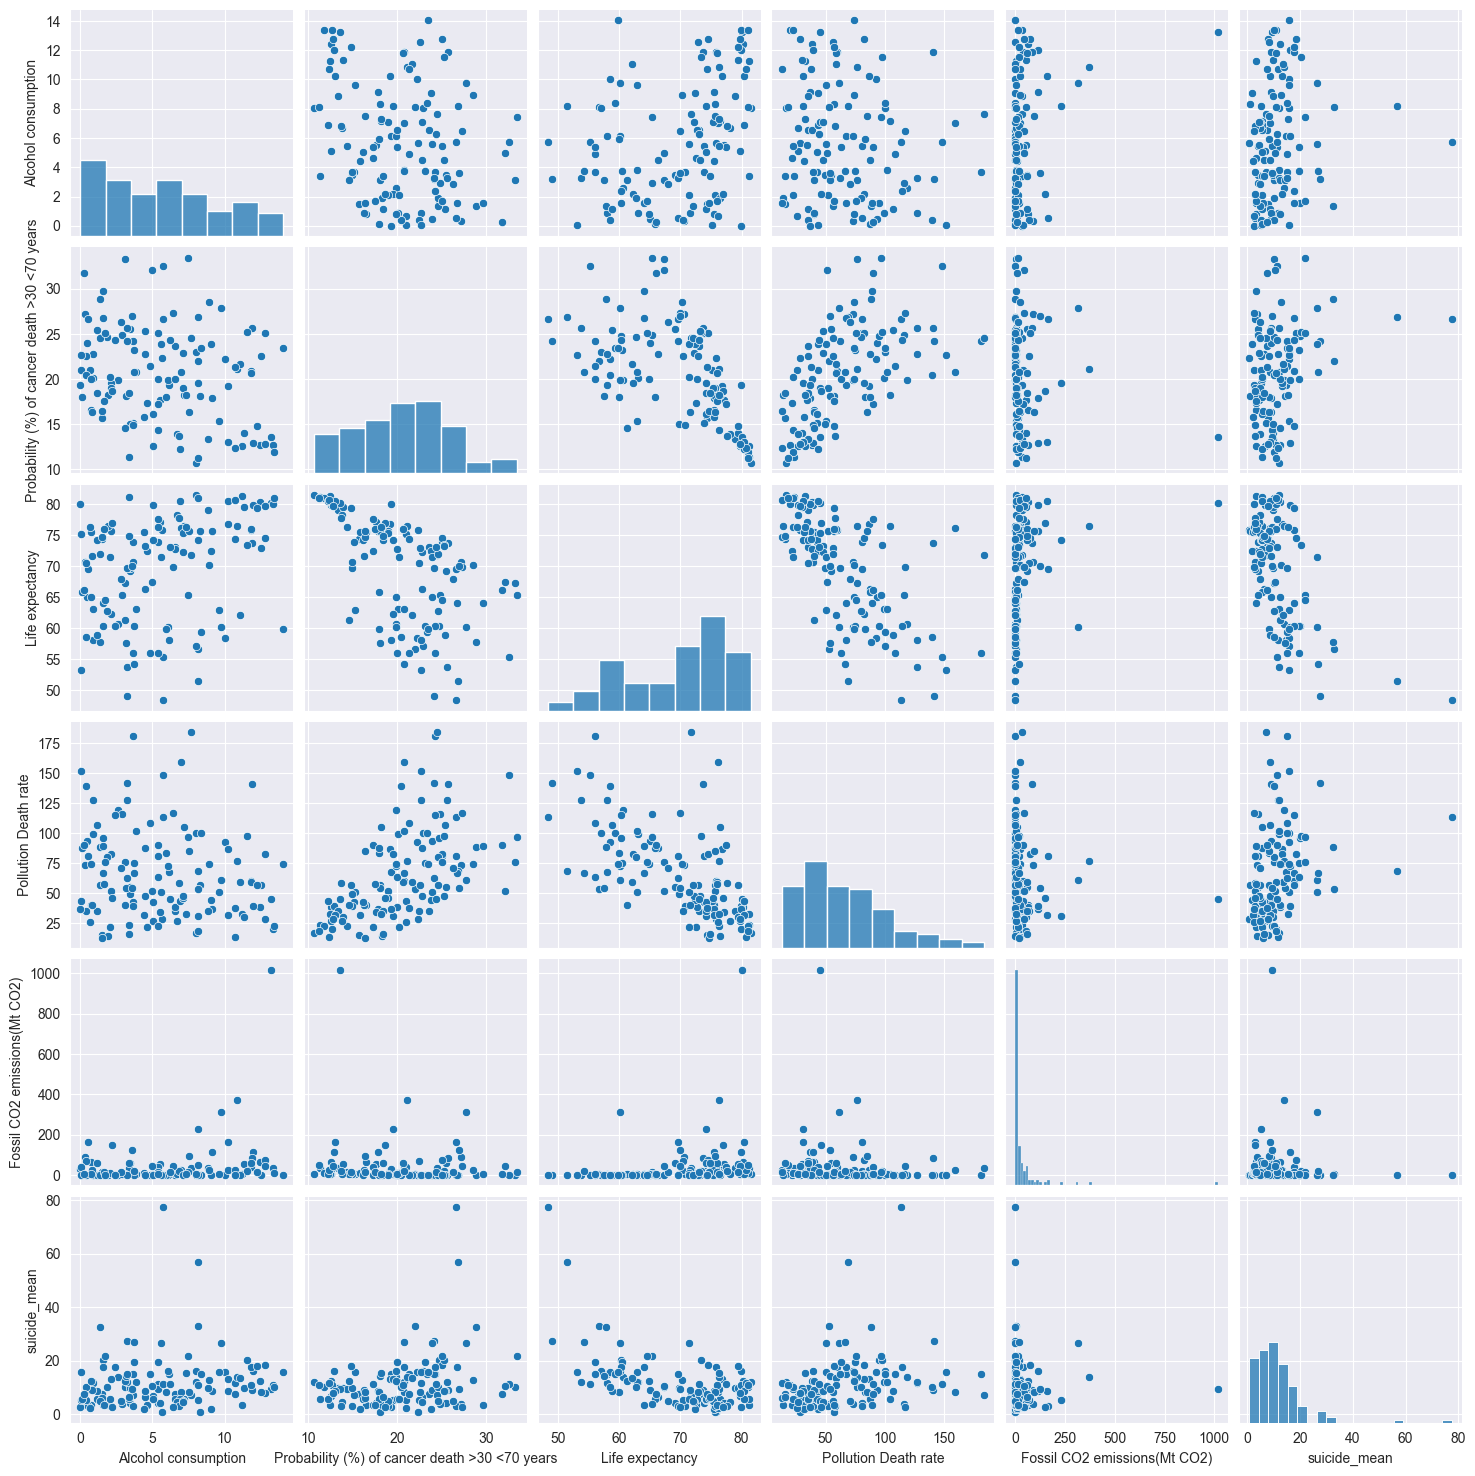

In [27]:
# Теперь мы можем посмотреть на корреляции по всем графикам
import seaborn as sns
sns.set_style("darkgrid")
sns.pairplot(final);

Самое явное - шанс умереть от рака и смертность от загрязнения (прямая) и шанс умереть от рака и ождиаемый срок жизни (обратная) зависимости. Emissions еще нужно нормализовать, чтобы получить корректнеые данные. Алкоголь же вроде как ни на что не влияет, как и на него ни на что не влияет